In [75]:
# Import Library

%matplotlib inline

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import re

from string import printable
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Flatten, Input, Conv2D, Conv1D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Lambda, Convolution1D, Convolution2D, ELU, concatenate
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping  
from tensorflow.keras.applications.resnet50 import ResNet50


import warnings
warnings.filterwarnings("ignore")

# 1. Autoencoder  

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of Dense layers.  We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.  

Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we've used with convolutional classification networks: Conv2d, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.  

An example to guide your thinking can be found towrad the bottom of this post https://blog.keras.io/building-autoencoders-in-keras.html. After training your network, visualize some examples of input image and their decoded reconstruction.

In [76]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [77]:
# Autoencoder

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

### Not sure why reshape to create a 4th dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Data normalization so values are between 0 and 1.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# one hot encoding the response variable. 
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [78]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)        4608      
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0   

In [79]:
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

autoencoder_history = autoencoder.fit(x_train, x_train,
                                      epochs=20,
                                      batch_size=2000,
                                      validation_data=(x_test, x_test),
                                      callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 107s 2ms/sample - loss: 0.6139 - accuracy: 0.4012 - val_loss: 0.6440 - val_accuracy: 0.5001
Epoch 2/20
60000/60000 [==============================] - 104s 2ms/sample - loss: 0.4733 - accuracy: 0.4784 - val_loss: 0.5827 - val_accuracy: 0.4999
Epoch 3/20
60000/60000 [==============================] - 108s 2ms/sample - loss: 0.4146 - accuracy: 0.4914 - val_loss: 0.5552 - val_accuracy: 0.4999
Epoch 4/20
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.3703 - accuracy: 0.4981 - val_loss: 0.5553 - val_accuracy: 0.4999
Epoch 5/20
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.3492 - accuracy: 0.5005 - val_loss: 0.5591 - val_accuracy: 0.4999
Epoch 6/20
60000/60000 [==============================] - 104s 2ms/sample - loss: 0.3387 - accuracy: 0.5014 - val_loss: 0.5488 - val_accuracy: 0.4999
Epoch 7/20
60000/60000 [==========================

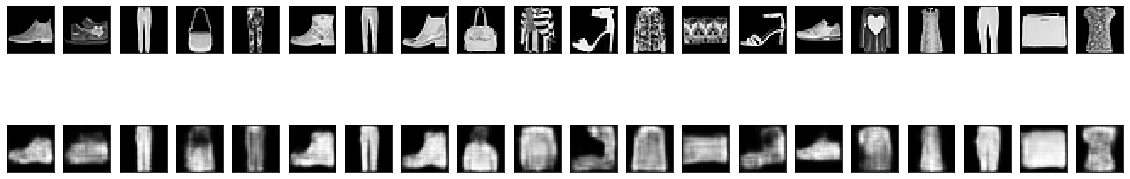

In [80]:
# Display original and reconstruction Images
decoded_imgs = autoencoder.predict(x_test)

def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[-i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[-i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

display_reconstructed(x_test, decoded_imgs, 20)

# 2. Image Classification

We'll Continue to use the Fashion MNIST dataset and build a deep convolutional network for classification.

# 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the architectural choices you've made: kernel size, strides, padding, network depth. Train your network end-to-end. Report on your model's performance on traning set and test set.

In [81]:
# Deep CNN

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)

# Data normalization; normalize values between 0 and 1.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

model = Sequential()
# Must define the input shape in the first layer of the neural network
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(108, activation='relu'))
model.add(Dropout(0.5))
# 10 classes
model.add(Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 128)       640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)            

In [82]:
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

deep_cnn_history = model.fit(x_train,
                             y_train,
                             batch_size=2000,
                             epochs=30,
                             validation_data=(x_test, y_test),
                             callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 58s 961us/sample - loss: 1.2984 - accuracy: 0.5205 - val_loss: 0.7036 - val_accuracy: 0.7446
Epoch 2/30
60000/60000 [==============================] - 57s 942us/sample - loss: 0.7074 - accuracy: 0.7395 - val_loss: 0.5320 - val_accuracy: 0.7988
Epoch 3/30
60000/60000 [==============================] - 57s 943us/sample - loss: 0.5847 - accuracy: 0.7863 - val_loss: 0.4709 - val_accuracy: 0.8256
Epoch 4/30
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.5236 - accuracy: 0.8128 - val_loss: 0.4299 - val_accuracy: 0.8419
Epoch 5/30
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.4874 - accuracy: 0.8248 - val_loss: 0.4063 - val_accuracy: 0.8512
Epoch 6/30
60000/60000 [==============================] - 58s 960us/sample - loss: 0.4622 - accuracy: 0.8355 - val_loss: 0.3874 - val_accuracy: 0.8577
Epoch 7/30
60000/60000 [========================

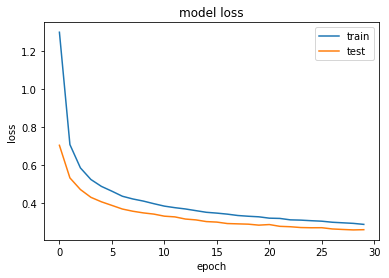

In [83]:
# Plot loss history
def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(deep_cnn_history)

# 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model's performance on training set and test set.

In [84]:
# Deep CNN

# shape is (60000, 28, 28)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# shape is (6000, 28, 84)
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test]*3)

# reshape to (60000, 28, 28, 3)
x_train = x_train.reshape(x_train.shape[0],28,28,3).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,3).astype('float32')


x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])


# Data normalization; normalize values between 0 and 1.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [85]:
x_train = preprocess_input(x_train)
x_test  = preprocess_input (x_test)

res_base = ResNet50(weights='imagenet',
                  include_top=False, 
                  input_shape=(48, 48, 3)
                 )

In [86]:
x = res_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

In [87]:
res_model = Model(res_base.input, output)
for layer in res_base.layers:
    layer.trainable = False

# Compile model
res_model.compile('adam',
                loss='categorical_crossentropy',
              metrics=['accuracy'])

res_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [88]:
eary_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

res_model_history = res_model.fit(
    x_train,
    y_train,
    epochs=30,
    callbacks=callbacks,
    validation_data=(x_test, y_test),
    batch_size=2000
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 377s 6ms/sample - loss: 1.3781 - accuracy: 0.5444 - val_loss: 2.6277 - val_accuracy: 0.1065
Epoch 2/30
60000/60000 [==============================] - 337s 6ms/sample - loss: 0.8652 - accuracy: 0.6977 - val_loss: 2.7580 - val_accuracy: 0.1726
Epoch 3/30
60000/60000 [==============================] - 317s 5ms/sample - loss: 0.7472 - accuracy: 0.7345 - val_loss: 3.0645 - val_accuracy: 0.1112
Epoch 4/30
60000/60000 [==============================] - 315s 5ms/sample - loss: 0.6752 - accuracy: 0.7599 - val_loss: 3.3284 - val_accuracy: 0.1023
Epoch 5/30
60000/60000 [==============================] - 315s 5ms/sample - loss: 0.6164 - accuracy: 0.7780 - val_loss: 3.5352 - val_accuracy: 0.1129
Epoch 6/30
60000/60000 [==============================] - 316s 5ms/sample - loss: 0.5712 - accuracy: 0.7936 - val_loss: 3.5736 - val_accuracy: 0.1066
Epoch 7/30
60000/60000 [==========================

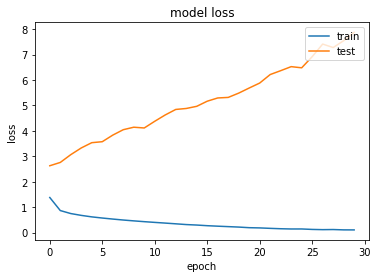

In [108]:
# Plot loss history
def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(res_model_history)

# 3 Text Classification

While images contrain local spatial correlations and strucutre, many other datasets contain temporal correlations. Examples include time series and discrete sequences such as text. In this problem, we will tackle the task of text classification in the context of natural language.  

In this problem, we will build models that read short text segments (tweets) and identify if one or more specific topics are being discussed.  

The dataset consists of tweets along with labels for which topics were being referenced in the tweet. Examples of the topics include "storms", "rain", "hurricane", "snow" and so on. Unlike previous classification problems we have encountered, in this dataset, there is not just a single right answer. The labels here are derived from multiple annotators decided how to label each tweet, so a single tweet can be about more than one topic. The label is the fraction of annocations for a given topic, and each row should sum to 1.  
What loss function should you use here? Categorical CrossEntropy might work, but with some modification since we don't have "hard" labels over the categories. Another option might be s igmoid: for each output category, use a sigmoid to collapse the output to be between 0 and 1, but each category output can be roughly independent of the others. In the problems below, feel free to try both. 

# 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM)

In [89]:
data = pd.read_csv("twitter-data/tweets_with_labels.csv", delimiter='\t')

In [90]:
data.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [91]:
tweets = [line for line in data.loc[:,'tweet'].values]

In [92]:
regexes=(
# Keep usernames together (any token starting with @, followed by A-Z, a-z, 0-9)        
r"(?:@[\w_]+)",

# Keep hashtags together (any token starting with #, followed by A-Z, a-z, 0-9, _, or -)
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",

# abbreviations, e.g. U.S.A.
r'(?:[A-Z]\.)+',
r'[A-Za-z]\.(?:[A-Za-z0-9]\.)+',
r'[A-Z][bcdfghj-np-tvxz]+\.',

# URL, e.g. https://google.com Ryans's url pattern.
r'https?:\/\/w{0,3}\.?[a-zA-Z0-9-]+\.[a-zA-Z0-9]{1,6}\/?[a-zA-Z0-9\/=]*\s*',
r'w{3}\.[a-zA-Z0-9]+\.[a-zA-Z0-9\/=]+\s*',
r'w{0:3}\.?[a-zA-Z0-9]+\.[a-zA-Z0-9\/=]+\/+[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.com\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.edu\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.gov\/?[a-zA-Z0-9\/=]*\s*',
r'[a-zA-Z0-9]+\.org\/?[a-zA-Z0-9\/=]*\s*',

# currency and percentages, e.g. $12.40, 82%
r'\$?\d+(?:\.\d+)?%?',

# Numbers i.e. 123,56.34
r'(?:[0-9]+[,]?)+(?:[.][0-9]+)?',

# Keep words with apostrophes, hyphens and underscores together
r"(?:[a-z][a-z’'\-_]+[a-z])",

# Keep all other sequences of A-Z, a-z, 0-9, _ together
r"(?:[\w_]+)",

# Match words at the end of a sentence.  e.g. tree. or tree!
r'(?:[a-z]+(?=[.!\?]))',

# Everything else that's not whitespace
# It seems like this captures punctuations and emojis and emoticons.  
#r"(?:\S)"
)
big_regex = "|".join(regexes)
my_extensible_tokenizer = re.compile(big_regex, re.VERBOSE | re.I | re.UNICODE)


In [93]:
all_tweets = []
for tweet in tweets:
    temp = []
    for match in my_extensible_tokenizer.findall(tweet):
        if match != '':
            temp.append(match)
    all_tweets.append(temp)

In [94]:
tokenizer = Tokenizer(num_words=None, lower=True, split=' ')
tokenizer.fit_on_texts(all_tweets)
sequences = tokenizer.texts_to_sequences(all_tweets)

In [95]:
# 46 = max length of tweet (number of words)
# Adding 0's to each tweet so every tweet has equal length.
for ele in sequences:
    if len(ele) < 46:
        ele.extend([0] * (46-len(ele)))

In [96]:
sequences = np.array(sequences)
sequences.shape
# There are 77946 different tweets and 46 is max length of tweet.
# 46 represents the vector dimension of each tweet.

(77946, 46)

In [97]:
# Determine number of vocabulary words
# There are 48220 different unique words.
curr = 0
for ele in sequences:
    for word in ele:
        if word > curr:
            curr = word 

In [98]:
target = data.loc[:, ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15']].as_matrix()

In [99]:
target.shape

(77946, 15)

In [100]:
x_train, x_test, y_train, y_test = train_test_split(sequences, target, test_size=0.25, random_state=33)

In [101]:
lstm_model = Sequential()

# Embedding layer
# input_dim = size of vocabulary + 1
# input_length = dimensions of tweet vector. 
lstm_model.add(
    Embedding(input_dim=48221,
              input_length = 46,
              output_dim=100,
              mask_zero=True))

# Recurrent layer
lstm_model.add(LSTM(128, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
lstm_model.add(Dense(64, activation='relu'))

# Dropout for regularization
lstm_model.add(Dropout(0.5))

# Output layer
lstm_model.add(Dense(15, activation='sigmoid'))

# Compile the model
lstm_model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 46, 100)           4822100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 15)                975       
Total params: 4,948,579
Trainable params: 4,948,579
Non-trainable params: 0
_________________________________________________________________


In [102]:
eary_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

lstm_model_history = lstm_model.fit(
    x_train,
    y_train,
    epochs=30,
    callbacks=callbacks,
    validation_data=(x_test, y_test),
    batch_size=2000
)

Train on 58459 samples, validate on 19487 samples
Epoch 1/30
58459/58459 [==============================] - 38s 657us/sample - loss: 3.0194 - accuracy: 0.2649 - val_loss: 2.7554 - val_accuracy: 0.2866
Epoch 2/30
58459/58459 [==============================] - 36s 609us/sample - loss: 2.7589 - accuracy: 0.2463 - val_loss: 2.6197 - val_accuracy: 0.2977
Epoch 3/30
58459/58459 [==============================] - 36s 620us/sample - loss: 2.6072 - accuracy: 0.2710 - val_loss: 2.4654 - val_accuracy: 0.3017
Epoch 4/30
58459/58459 [==============================] - 37s 637us/sample - loss: 2.4269 - accuracy: 0.3049 - val_loss: 2.2144 - val_accuracy: 0.3223
Epoch 5/30
58459/58459 [==============================] - 37s 627us/sample - loss: 2.1367 - accuracy: 0.3816 - val_loss: 1.8151 - val_accuracy: 0.4342
Epoch 6/30
58459/58459 [==============================] - 37s 632us/sample - loss: 1.8225 - accuracy: 0.5013 - val_loss: 1.6197 - val_accuracy: 0.5737
Epoch 7/30
58459/58459 [====================

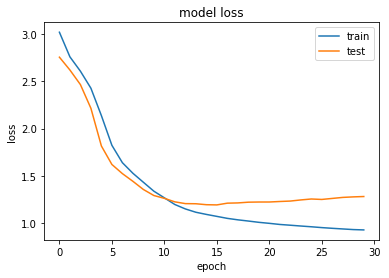

In [103]:
# Plot loss history
def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(lstm_model_history)

# 3.2 CNN

Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings). You might gain some insight and inspiration from these text classfication approaches:

• http://www.aclweb.org/anthology/D14-1181
• https://arxiv.org/abs/1702.08568

In [104]:
cnn_model = Sequential()
# Embedding layer
# input_dim = size of vocabulary + 1
# input_length = dimensions of tweet vector. 
cnn_model.add(
    Embedding(input_dim=48221,
              input_length = 46,
              output_dim=100,
              mask_zero=True))
# Must define the input shape in the first layer of the neural network
cnn_model.add(Conv1D(filters=258, kernel_size=2, padding='same', activation='relu')) 
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=258, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(200, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.5))
# 15 classes
cnn_model.add(Dense(15, activation='sigmoid'))
# Take a look at the model summary
cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 46, 100)           4822100   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 46, 258)           51858     
_________________________________________________________________
dropout_28 (Dropout)         (None, 46, 258)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 46, 258)           199950    
_________________________________________________________________
dropout_29 (Dropout)         (None, 46, 258)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 46, 128)           132224    
_________________________________________________________________
dropout_30 (Dropout)         (None, 46, 128)         

In [105]:
eary_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

cnn_model_history = cnn_model.fit(
    x_train,
    y_train,
    epochs=30,
    callbacks=callbacks,
    validation_data=(x_test, y_test),
    batch_size=2000
)

Train on 58459 samples, validate on 19487 samples
Epoch 1/30
58459/58459 [==============================] - 55s 944us/sample - loss: 2.8881 - accuracy: 0.1921 - val_loss: 2.7190 - val_accuracy: 0.2852
Epoch 2/30
58459/58459 [==============================] - 55s 934us/sample - loss: 2.7122 - accuracy: 0.2483 - val_loss: 2.5876 - val_accuracy: 0.2852
Epoch 3/30
58459/58459 [==============================] - 55s 936us/sample - loss: 2.5795 - accuracy: 0.2677 - val_loss: 2.4661 - val_accuracy: 0.2856
Epoch 4/30
58459/58459 [==============================] - 54s 923us/sample - loss: 2.4376 - accuracy: 0.2860 - val_loss: 2.1935 - val_accuracy: 0.3090
Epoch 5/30
58459/58459 [==============================] - 56s 955us/sample - loss: 2.1880 - accuracy: 0.3336 - val_loss: 2.0913 - val_accuracy: 0.3826
Epoch 6/30
58459/58459 [==============================] - 55s 946us/sample - loss: 2.0829 - accuracy: 0.3704 - val_loss: 1.9852 - val_accuracy: 0.4202
Epoch 7/30
58459/58459 [====================

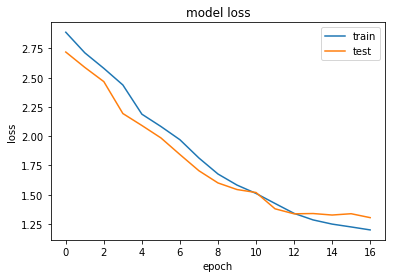

In [106]:
# Plot loss history
def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(cnn_model_history)

# 3.3 

Be sure to directly compare your two metthods with an ROC curve or similar validation method. Don't forget to create a train-test split.

In [107]:
# LSTM and CNN ROC Curve
y_pred_keras = lstm_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

cnn_y_pred_keras = cnn_model.predict(x_test).ravel()
cnn_fpr_keras, cnn_tpr_keras, cnn_thresholds_keras = roc_curve(y_test, cnn_y_pred_keras)
cnn_auc_keras = auc(cnn_fpr_keras, cnn_tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.plot(cnn_fpr_keras, cnn_tpr_keras, label='CNN (area = {:.3f})'.format(cnn_auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ValueError: continuous-multioutput format is not supported